In [ ]:
# run if using google colab
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/FCN')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import regularizers, initializers, Input, Model
from keras.layers import MaxPool2D, Conv2D, Conv2DTranspose, Lambda, Dropout, Add, UpSampling2D, concatenate
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm #to create a task bar
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

#import data, models

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [ ]:
def split_dataset(DATASET_PATH, holdout=0.8):
  for dirname in os.listdir(DATASET_PATH):
    if dirname=='images':
      images = [os.path.join(DATASET_PATH, dirname, filename) for filename in os.listdir(os.path.join(DATASET_PATH, dirname)) if dirname=='images']
    else:
      masks = [os.path.join(DATASET_PATH, dirname, filename) for filename in os.listdir(os.path.join(DATASET_PATH, dirname)) if dirname=='masks']

  images.sort()
  masks.sort()

  return train_test_split(images, masks, test_size=1-holdout, random_state=np.random.randint(0,1e6))

# Data augmentation

In [ ]:
def augment_data(images, masks, save_list_images, save_list_masks, save_path=None):
    H = 512
    W = 512

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        aug = CenterCrop(600, 600, p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented["image"]
        y1 = augmented["mask"]

        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        aug = GridDistortion(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x5 = augmented['image']
        y5 = augmented['mask']

        save_images = [x1, x2, x3, x4, x5]
        save_masks =  [y1, y2, y3, y4, y5]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"

            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"
            if save_path:
              image_path = os.path.join(save_path, "images", tmp_img_name)
              mask_path = os.path.join(save_path, "masks", tmp_mask_name)

              cv2.imwrite(image_path, i)
              cv2.imwrite(mask_path, m)

            save_list_images.append(i)
            save_list_masks.append(m)


            idx += 1

# Models

In [ ]:
def conv_block(x, filters):
  x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
  x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)

  return x

In [ ]:
def downsample_block(x, filters, weight_decay=0.3):
  f = conv_block(x, filters)
  p = MaxPool2D(2)(f)
  p = Dropout(rate=weight_decay)(p)

  return f, p


In [ ]:
def upsample_block(x, conv_features, filters, weight_decay=0.3):
  x = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(x)
  x = concatenate([x, conv_features])
  x = Dropout(rate=weight_decay)(x)
  x = conv_block(x, filters)

  return x


In [ ]:
#unet
def build_unet_model():
  input = Input(shape=(512, 512, 3), name='input_layer')

  #encoder
  f1, p1 = downsample_block(input, 64)

  f2, p2 = downsample_block(p1, 128)

  f3, p3 = downsample_block(p2, 256)

  f4, p4 = downsample_block(p3, 512)

  #bottleneck
  bottleneck = conv_block(p4, 1024)

  #decoder
  u6 = upsample_block(bottleneck, f4, 512)

  u7 = upsample_block(u6, f3, 256)

  u8 = upsample_block(u7, f2, 128)

  u9 = upsample_block(u8, f1, 64)

  #output
  output = Conv2D(3, 1, padding='same', activation='sigmoid')(u9)

  #build model
  model = Model(input, output, name='U-Net')

  return model

In [ ]:
#vgg and fcn's

def vgg16(l2=0, dropout=0):
    '''Convolutionized VGG16 network. 
    Args:
      l2 (float): L2 regularization strength
      dropout (float): Dropout rate
    Returns:
      (keras Model)
    '''
    ## Input
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    ## Preprocessing
    #x = keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name='preprocessing')(input_layer)
    ## Block 1
    x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv1')(input_layer)
    x = keras.layers.Conv2D(filters=64, kernel_size=3,  strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv2')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool')(x)
    ## Block 2
    x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv1')(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=3,  strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv2')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool')(x)
    ## Block 3
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv1')(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv2')(x)
    x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv3')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')(x)
    ## Block 4
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv1')(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv2')(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv3')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)
    ## Block 5
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv1')(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv2')(x)
    x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv3')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)
    ## Convolutionized fully-connected layers
    x = keras.layers.Conv2D(filters=4096, kernel_size=(7,7), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv6')(x)
    x = keras.layers.Dropout(rate=dropout, name='drop6')(x)
    x = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu',
                            kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv7')(x)
    x = keras.layers.Dropout(rate=dropout, name='drop7')(x)
    ## Inference layer
    x = keras.layers.Conv2D(filters=1000, kernel_size=(1,1), strides=(1,1), padding='same', activation='softmax', 
                            name='pred')(x)
    return keras.Model(input_layer, x)



def fcn32s(vgg16, l2=0):
    '''32x upsampled FCN.
    Args:
      vgg16 (keras Model): VGG16 model to build upon
      l2 (float): L2 regularization strength
    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2D(filters=3, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score7')(vgg16.get_layer('drop7').output)
    x = keras.layers.Conv2DTranspose(filters=3, kernel_size=(64,64), strides=(32,32),
                                     padding='same', use_bias=False, activation='sigmoid',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn32')(x)
    return keras.Model(vgg16.input, x)



def fcn16s(vgg16, fcn32, l2=0):
    '''16x upsampled FCN.
    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn32 (keras Model): FCN32 model to build upon
      l2 (float): L2 regularization strength
    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='score7_upsample')(fcn32.get_layer('score7').output)
    y = keras.layers.Conv2D(filters=3, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score4')(vgg16.get_layer('block4_pool').output)
    x = keras.layers.Add(name='skip4')([x, y])
    x = keras.layers.Conv2DTranspose(filters=3, kernel_size=(32,32), strides=(16, 16),
                                     padding='same', use_bias=False, activation='sigmoid',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn16')(x)
    return keras.Model(fcn32.input, x)



def fcn8s(vgg16, fcn16, l2=0):
    '''8x upsampled FCN.
    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn16 (keras Model): FCN16 model to build upon
      l2 (float): L2 regularization strength
    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=3, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='skip4_upsample')(fcn16.get_layer('skip4').output)
    y = keras.layers.Conv2D(filters=3, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score3')(vgg16.get_layer('block3_pool').output)
    x = keras.layers.Add(name='skip3')([x, y])
    x = keras.layers.Conv2DTranspose(filters=3, kernel_size=(16,16), strides=(8,8),
                                     padding='same', use_bias=False, activation='sigmoid',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn8')(x)
    return keras.Model(fcn16.input, x)

class BilinearInitializer(keras.initializers.Initializer):
  '''Initializer for Conv2DTranspose to perform bilinear interpolation on each channel.'''
  def __call__(self, shape, dtype=None, **kwargs):
    kernel_size, _, filters, _ = shape
    arr = np.zeros((kernel_size, kernel_size, filters, filters))
    ## make filter that performs bilinear interpolation through Conv2DTranspose
    upscale_factor = (kernel_size+1)//2
    if kernel_size % 2 == 1:
        center = upscale_factor - 1
    else:
        center = upscale_factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    kernel = (1-np.abs(og[0]-center)/upscale_factor) * \
              (1-np.abs(og[1]-center)/upscale_factor) # kernel shape is (kernel_size, kernel_size)
    for i in range(filters):
        arr[..., i, i] = kernel
    return tf.convert_to_tensor(arr, dtype=dtype)

In [ ]:
## UNet base model

unet_model_2 = build_unet_model()

In [ ]:
# ## VGG16 base model
vgg_model = vgg16(l2=1e-6, dropout=0.2)

In [ ]:
# ## FCN32
fcn32 = fcn32s(vgg_model, l2=1e-6)

# ## freeze upsample layer
# #fcn32.get_layer('FCN32s').trainable=False

In [ ]:
# ## FCN16
fcn16 = fcn16s(vgg_model, fcn32, l2=1e-6)

# ## freeze upsample layer
# #fcn16.get_layer('upsample-conv7').trainable=False
# #fcn16.get_layer('FCN16s').trainable=False

In [ ]:
# ## FCN8
fcn8 = fcn8s(vgg_model, fcn16, l2=1e-6)

# ## freeze upsample layer
# #fcn8.get_layer('upsample-step4').trainable=False

# Training

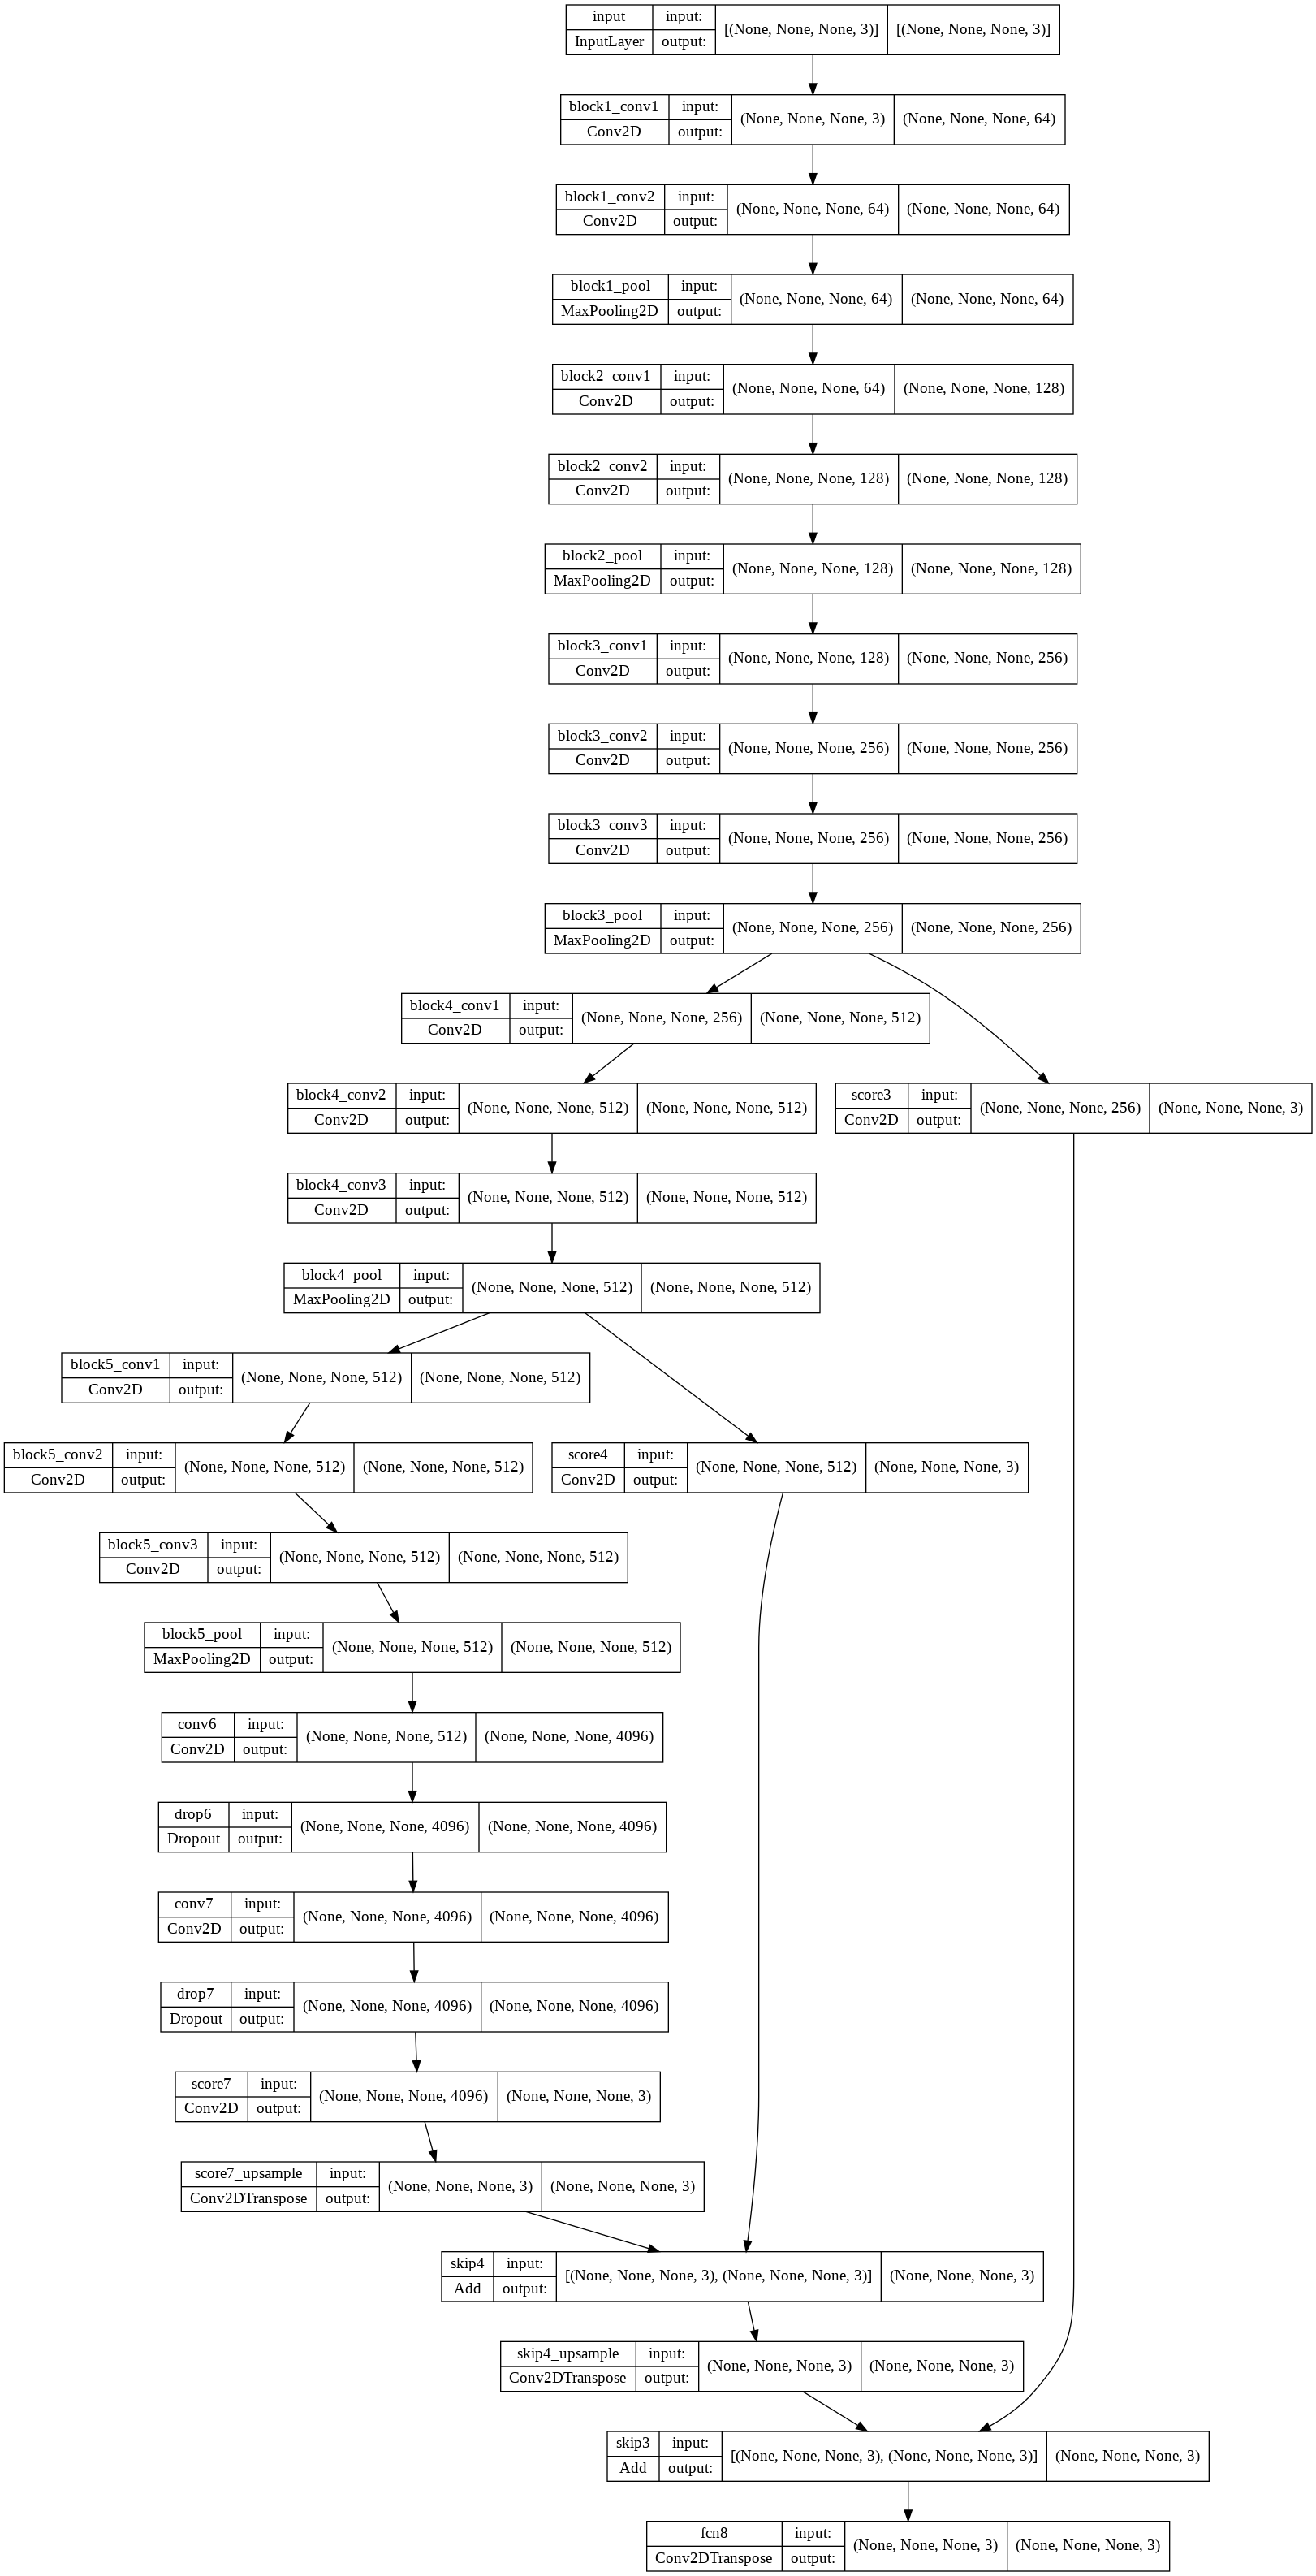

In [ ]:
## Load model
model = fcn8
#model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
## Train and test datasets
X_train, X_test, y_train, y_test = split_dataset('/content/drive/MyDrive/rats_data', holdout=0.8)

In [ ]:
X_train_images = []
for image in X_train:
  img = cv2.imread(image).astype(np.float32) / 255.0
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = tf.image.resize(img, (512, 512), method="bilinear")
  
  X_train_images.append(img)

In [ ]:
X_test_images = []
for image in X_test:
  img = cv2.imread(image).astype(np.float32) / 255.0
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = tf.image.resize(img, (512, 512), method="bilinear")
  X_test_images.append(img)

In [ ]:
y_train_images = []
for image in y_train:
  img = cv2.imread(image).astype(np.float32) / 255.0
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img[img > 0.5] = 1
  img[img <= 0.5] = 0
  img = tf.image.resize(img, (512, 512), method="bilinear")
  y_train_images.append(img)

In [ ]:
y_test_images = []
for image in y_test:
  img = cv2.imread(image).astype(np.float32) / 255.0
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img[img > 0.5] = 1
  img[img <= 0.5] = 0
  img = tf.image.resize(img, (512, 512), method="bilinear")
  y_test_images.append(img)

In [ ]:
print(f"Original Images: {len(X_train_images)} - Original Masks: {len(y_train_images)}")
augment_data(X_train, y_train, X_train_images, y_train_images, save_path='/content/drive/MyDrive/rats_data')
print(f"\nAugmented Images: {len(X_train_images)} - Augmented Masks: {len(y_train_images)}")

print(f"\n\nOriginal Images: {len(X_test_images)} - Original Masks: {len(y_test_images)}")
augment_data(X_test, y_test, X_test_images, y_test_images, save_path='/content/drive/MyDrive/rats_data')
print(f"\nAugmented Images: {len(X_test_images)} - Augmented Masks: {len(y_test_images)}")

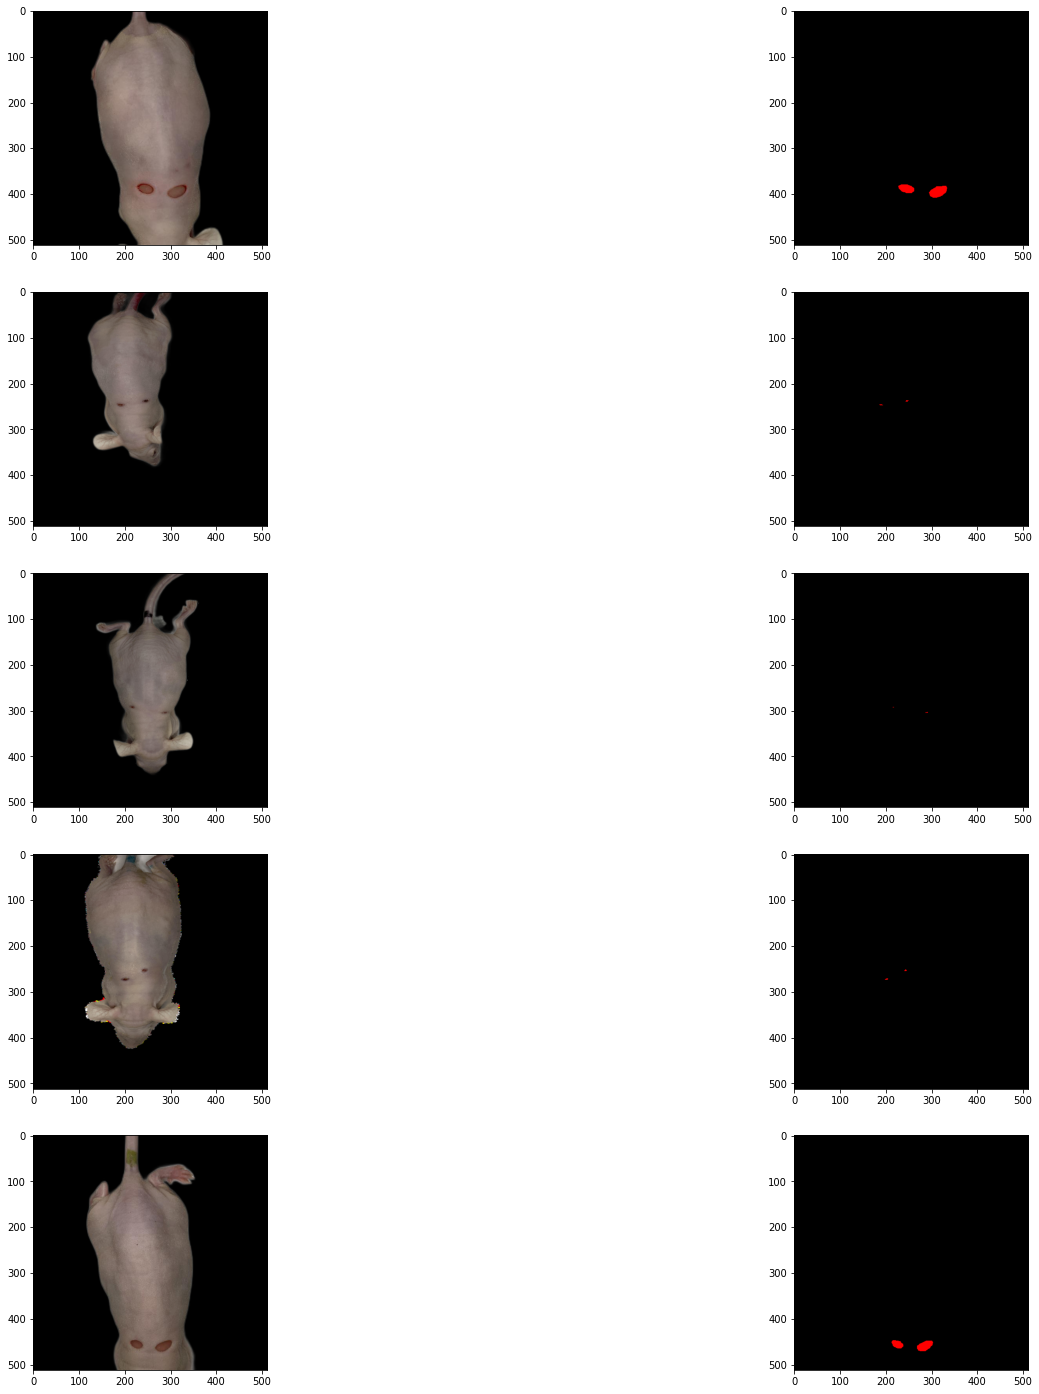

In [ ]:
#checking the data

n = 5
plt.figure(figsize=(25, 25))
for i in range(n):
  plt.subplot(n, 2, 2*i+1)
  plt.imshow(X_train_images[i])
  plt.subplot(n, 2, 2*i+2)
  plt.imshow(y_train_images[i])

In [ ]:
X_train_images = tf.convert_to_tensor(X_train_images)
y_train_images = tf.convert_to_tensor(y_train_images)
X_test_images = tf.convert_to_tensor(X_test_images)
y_test_images = tf.convert_to_tensor(y_test_images)

In [ ]:
print(X_train_images.shape)
print(y_train_images.shape)
print(X_test_images.shape)
print(y_test_images.shape)

(364, 512, 512, 3)
(364, 512, 512, 3)
(92, 512, 512, 3)
(92, 512, 512, 3)


In [ ]:
## compile

opt = keras.optimizers.Adam(learning_rate=1e-2)
loss = ['binary_crossentropy']
metrics = [
    'binary_accuracy',
    tf.keras.metrics.MeanIoU(num_classes=2)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
history = model.fit(X_train_images, y_train_images, batch_size=4, epochs=5, verbose=1)

Epoch 1/5
91/91 [==============================] - 5329s 59s/step - loss: 129234.2734 - binary_accuracy: 0.9167 - mean_io_u_2: 0.4592
Epoch 2/5
 1/91 [..............................] - ETA: 1:27:34 - loss: 1.4744 - binary_accuracy: 0.9997 - mean_io_u_2: 0.4999

In [ ]:
#Plot the loss curves

import pandas as pd

pd.DataFrame(history.history).plot()

In [ ]:
img = cv2.imread('/content/drive/MyDrive/rats_data/images/A3_Mar2_10ng_D0_1.png').astype(np.float32) / 255.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.image.resize(img, (512, 512), method="bilinear")
img = tf.convert_to_tensor(img)
y_pred = model(img[None])[0]

In [ ]:
y_pred = np.array(y_pred)
y_pred[y_pred > 0.08] = 1

In [ ]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(y_pred)

plt.show()